In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, Dropout, LSTM,Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D, SimpleRNN, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, classification_report
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

In [10]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/AWGN/noise_data_awgn_snr_minusfive_final_large_big_new1.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,32), axis=1)
    Y2 = new_data[:,32]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42, shuffle=True)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [11]:
flip_bit_data = get_data()

In [12]:
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

In [5]:
X_test.shape

(230000, 1, 31)

# 1. Build LSTM Network

In [13]:
num_neurons = 31
num_features = 31


model = Sequential()
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=True))
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.summary()

print("inputs: " , model.input_shape)
print("outputs: ", model.output_shape)
print("actual inputs: ", np.shape(X_train))
print("actual outputs: ", np.shape(y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 31)             7812      
_________________________________________________________________
lstm_1 (LSTM)                (None, 31)                7812      
_________________________________________________________________
dense (Dense)                (None, 1)                 32        
Total params: 15,656
Trainable params: 15,656
Non-trainable params: 0
_________________________________________________________________
inputs:  (None, 1, 31)
outputs:  (None, 1)
actual inputs:  (390000, 1, 31)
actual outputs:  (390000,)


In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
print('Training LSTM...')

batch_size = 5

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

Training LSTM...
Train on 390000 samples, validate on 130000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
390000/390000 [==============================] - 305s 781us/sample - loss: 0.1445 - acc: 0.9440 - val_loss: 0.1378 - val_acc: 0.9462
Epoch 2/5
390000/390000 [==============================] - 295s 757us/sample - loss: 0.1383 - acc: 0.9465 - val_loss: 0.1413 - val_acc: 0.9451
Epoch 3/5
390000/390000 [==============================] - 319s 817us/sample - loss: 0.1360 - acc: 0.9471 - val_loss: 0.1393 - val_acc: 0.9463
Epoch 4/5
390000/390000 [==============================] - 345s 886us/sample - loss: 0.1345 - acc: 0.9479 - val_loss: 0.1402 - val_acc: 0.9450
Epoch 5/5
130000/130000 [==============================] - 39s 304us/sample - loss: 0.1368 - acc: 0.9464 - loss: 0.1364 - - ETA: 1


In [17]:
print('score:', score)
print('accuracy:', acc)

score: 0.1368397083139414
accuracy: 0.94636154


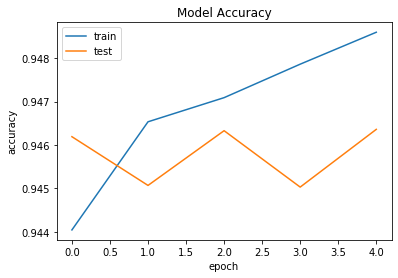

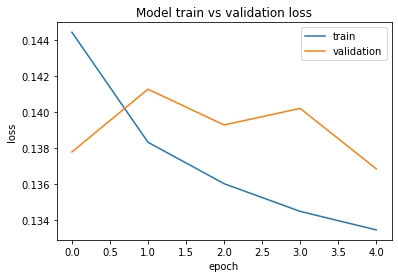

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
# Let's save the model to disc
json = model.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snr_minus5.json", "w") as file:
    file.write(json)
model.save_weights("/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snr_minus5.h5")
print("Saved model to disc")

Saved model to disc


In [13]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snr_minus5.json', 'r')
json = json_file.read()
json_file.close()
model_one_from_disc = model_from_json(json)
model_one_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snr_minus5.h5")

In [6]:
y_pred_from_disk = model_one_from_disc.predict(X_test, batch_size=1, verbose=1)

230000/230000 [==============================] - 358s 2ms/sample


In [23]:
pred = pd.DataFrame(y_pred_from_disk, columns =['Y_pred']) 
pred['Label'] = y_test

In [24]:
pred.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/LSTM/AWGN/model_one_snr_minus5.csv', index = False)

In [7]:
yhat = model_one_from_disc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.469592, G-Mean=0.948


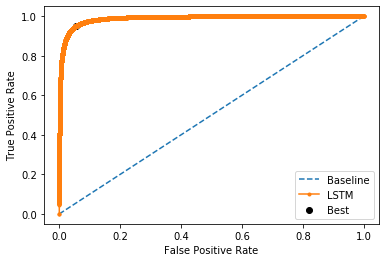

In [8]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='LSTM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig('/Users/niall/Documents/Cypress_Code/Plots/Matlab_awgn/LSTM_ROC.jpg')
plt.show()

In [9]:
auc = roc_auc_score(y_test, yhat)
print('ROC AUC=%.3f' % (auc))

ROC AUC=0.989


In [14]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
preds_new = model_one_from_disc.predict_classes(X_test)
metrics(preds_new, y_test)

F1-score:  0.9462064053771337
Precision:  0.9452092559984347
Recall:  0.947205660864993
Acuracy:  0.9474565217391304
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    117791
           1       0.95      0.95      0.95    112209

    accuracy                           0.95    230000
   macro avg       0.95      0.95      0.95    230000
weighted avg       0.95      0.95      0.95    230000

